In [2]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [3]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [4]:
import matplotlib.pyplot as plt

# Dataset

In [5]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [6]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-20 16:15:07.799754: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [104]:
def mlp(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x)
    
    x0 = conv_1d(128)(x, spiking=spiking, **kwargs)
    x1 = conv_1d(10)(x0,  spiking=spiking, **kwargs)

    if spiking: 
        p = train_to_phase(x1, offset=0.25)
        #best_cycle = dphase_min(p)
        best_cycle = -1
        p = p[:,:,best_cycle]
        
        sp_0 = spiking_sparsity(x0)
        sp_1 = spiking_sparsity(x1)

        return p, (sp_0, sp_1)
    else:
        sp_0 = matrix_sparsity(x0)
        sp_1 = matrix_sparsity(x1)

        return x1, (sp_0, sp_1)

In [105]:
#declare the model as a transformation
model = hk.transform(mlp)

In [97]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [98]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [12]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [13]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


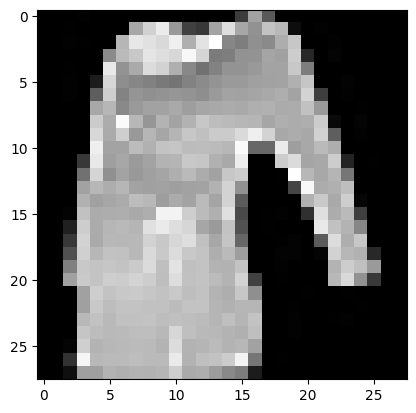

In [14]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

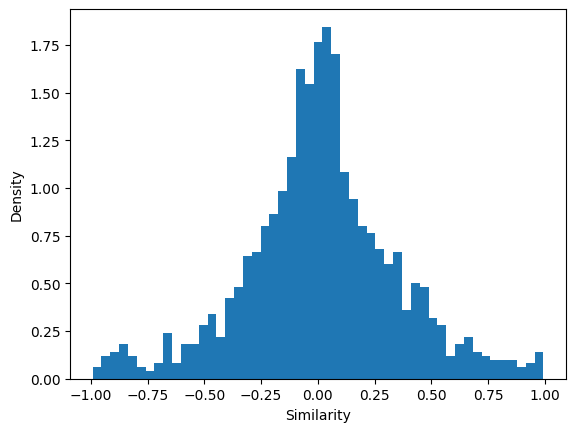

In [15]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred, sp = model.apply(params, key, x)

plt.hist(np.array(pred.ravel()), bins=51, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

In [16]:
sp

(DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32))

Text(0, 0.5, 'Density')

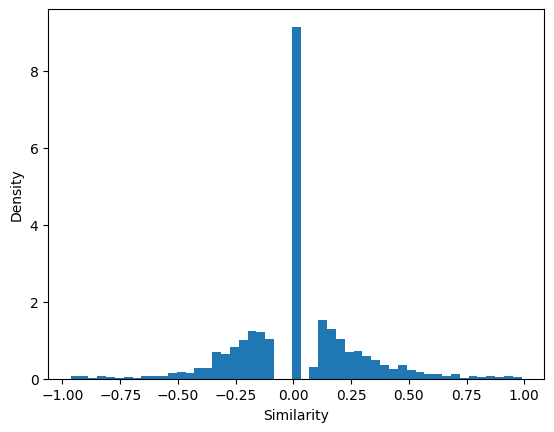

In [17]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred, sp = model.apply(params, key, x, mask_angle = 0.10, spiking=False)

plt.hist(np.array(pred.ravel()), bins=51, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")


In [18]:
sp

(DeviceArray(0.3468628, dtype=float32), DeviceArray(0.35, dtype=float32))

In [19]:
loss_fn = lambda yh, y: quadrature_loss(yh[0], y, num_classes=10)

In [20]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn((pred, sp), y))

DeviceArray(0.34420824, dtype=float32)

# Training

In [21]:
mask_angles = np.linspace(0.0, 0.15, 16)

In [22]:
mask_angles

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15])

In [23]:
train_fn = lambda x: train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 1000,
                               mask_angle = x)

results = list(map(train_fn, mask_angles))

100%|██████████| 1000/1000 [00:32<00:00, 31.03it/s]


In [24]:
all_losses = np.stack([r[1] for r in results])

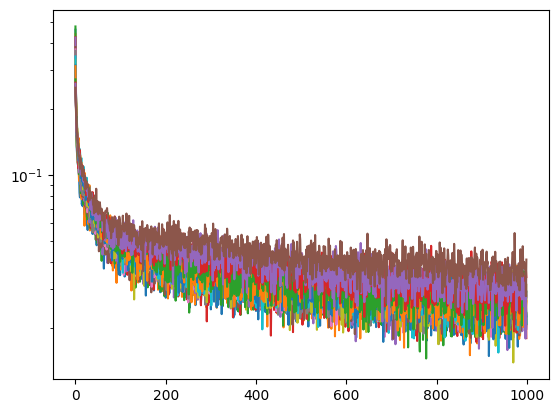

In [25]:
plt.semilogy(all_losses.transpose());

# Test

In [83]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [84]:
def evaluate(network, params, key, batch, mask_angle: float = -1.0, spiking: bool = False):
    x = batch['image']
    y = batch['label']

    yhat, sparsity = network.apply(params, key, x, mask_angle = mask_angle, spiking = spiking)
    acc = accuracy_quadrature(yhat, y)
    
    return (acc, sparsity)

In [106]:
eval_nospk = lambda b, p, ma: evaluate(model, p, key, b, mask_angle=ma, spiking=False)
eval_spk = lambda b, p, ma: evaluate(model, p, key, b, mask_angle=ma, spiking=True)


In [86]:
def dispatch_evaluation(eval_fn, all_parameters, mask_angles):
    n = len(mask_angles)
    assert len(all_parameters) == n, "Must have set of parameters for each mask angle"


    def inner_fn(i):
        parameters = all_parameters[i][0]
        mask_angle = mask_angles[i]

        results = [eval_fn(b, parameters, mask_angle) for b in iter(test_ds)]
        acc = np.mean(jnp.concatenate([b[0] for b in results]))
        sparsity = np.mean(jnp.stack([np.array(b[1]) for b in results], axis=0), axis=0)

        return np.array([acc, *sparsity])
    
    all_results = np.stack(list(map(inner_fn, range(n))))

    return all_results

In [87]:
nospk_result = dispatch_evaluation(eval_nospk, results, mask_angles)

Compute accuracy across mask angles

In [88]:
all_accs = nospk_result[:,0]

In [89]:
all_accs.shape

(16,)

In [90]:
all_sparsity = nospk_result[:,1:]

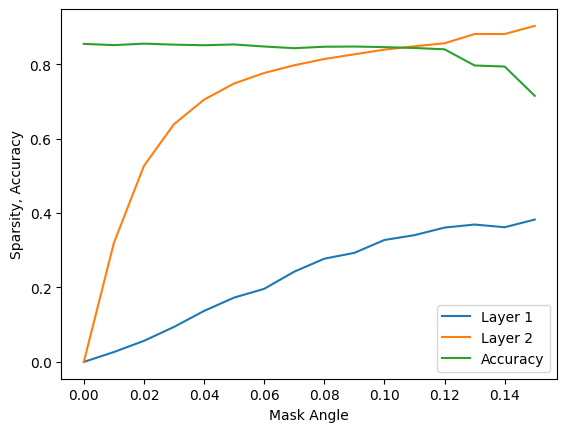

In [91]:
plt.plot(mask_angles, all_sparsity[:,0], label="Layer 1")
plt.plot(mask_angles, all_sparsity[:,1], label="Layer 2")
plt.plot(mask_angles, all_accs, label="Accuracy")
plt.ylabel("Sparsity, Accuracy")
plt.xlabel("Mask Angle")
plt.legend()

Compute spiking accuracy / sparsity

In [108]:
spk_result = dispatch_evaluation(eval_spk, results[0:1], mask_angles[0:1])

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 450.75it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 4955.52it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 450.83it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5060.41it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 531.38it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5118.69it/s]


Solving layer phasor_dense


100%|██████████| 1001/1001 [00:02<00:00, 450.66it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 5087.13it/s]


Solving layer phasor_dense


 23%|██▎       | 230/1001 [00:00<00:01, 531.46it/s]

In [107]:
spk_result

array([[0.7729   , 1.0069003, 1.0092416]], dtype=float32)

In [ ]:
spk_result

array([[0.7729   , 1.0069003, 1.0092416]], dtype=float32)

In [35]:
batch = dict({"image": x, "label": y})

In [36]:
phases, sparsity = model.apply(results[0][0], key, x, mask_angle = 0.0, spiking = True)

Solving layer phasor_dense


100%|██████████| 1001/1001 [00:01<00:00, 545.94it/s]


Solving layer phasor_dense_1


100%|██████████| 1001/1001 [00:00<00:00, 3827.17it/s]


In [91]:
mean_accuracies = np.array([jnp.mean(spk_accs[i], axis=1) for i in range(len(mask_angles))])

In [92]:
mean_accuracies.shape

(16, 11)

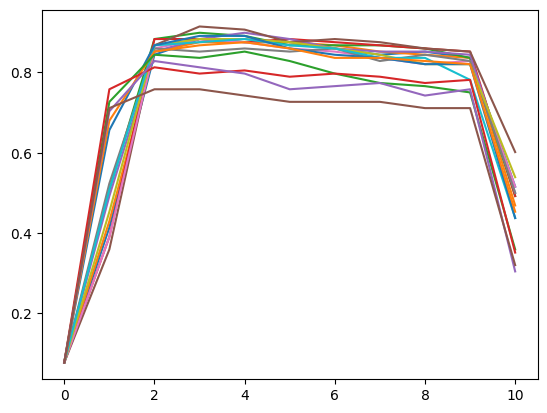

In [95]:
plt.plot(mean_accuracies.transpose());